In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

sns.set_context('paper')
data_dir = Path('../data')
input_dir = data_dir / 'input'
output_dir = data_dir / 'output'
figure_dir = Path("../figures")

df = pd.read_csv(output_dir / '04_language_detection.csv',
                 parse_dates=['created', 'deposited'])

### Completeness and Quality issues

Dividing issues between 'Completeness' and 'Quality' and getting the sum of issues for each record

In [2]:
completeness = ['no_author', 'no_language', 'no_title', 
                'no_abstract', 'author_characters', 'affiliation_missing']
quality = ['author_sequence', 'author_institutions',
           'abstract_multi_lang', 'title_language', 
           'author_uppercase','author_honorific']
df['completeness_errors'] = df[completeness].sum(axis=1)
df['quality_errors'] = df[quality].sum(axis=1)

### Categorization

Initially, we simply labeled records according to these groupings, here we are doing to change their `dtype` to a categorical one. Applying to both Publisher Size as well as Language Type.

In [3]:
cat_size_order = pd.api.types.CategoricalDtype(
    ['XS', 'S', 'M', 'L', 'XL'], 
    ordered=True
)

cat_lang_order = pd.api.types.CategoricalDtype(
    ['Multilingual', 'Monolingual Non-English', 'Monolingual English'],
    ordered=True
)
df['publisher_bin'] = df['publisher_bin'].astype(cat_size_order)
df['lang_type'] = df['lang_type'].astype(cat_lang_order)
pivot = pd.pivot_table(df, values='quality_errors', index='publisher_bin',
                       columns=['lang_type'], aggfunc=np.mean)

/tmp/ipykernel_206361/179859205.py:12: FutureWarning: The provided callable <function mean at 0x7f29381ab640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(df, values='quality_errors', index='publisher_bin',


### Renaming

Renaming the columns relevant to the visualizations for cleaner appearance in viz.

In [4]:
palette = ['coral', 'thistle', 'skyblue']
sns.set_context('paper')
df2 = df.rename({'publisher_bin':'Publisher Size', 'lang_type': 'Language Type',
                 'no_author': 'Authors', 'no_language': 'Language',
                 'no_abstract' : 'Abstract', 'no_title' : 'Title',
                 'author_characters': 'Language Style', 'author_institutions': 'Affiliation as Author',
                 'author_sequence': 'Author Sequence', 'title_language': 'Language Does Not Match',
                 'author_initials': 'Only Initials Provided',
                 'abstract_multi_lang' : 'Multilingual Abstract',
                 'author_honorific': 'Honorific in Name',
                 'author_uppercase':'Author Name in All Caps',
                 'affiliation_missing':'Affiliation'}, axis=1)

### Completeness Issues

**Figure 2**

Viz for showing completeness issues, Grouped bar chart for seeing differences between language types.

/tmp/ipykernel_206361/3166679016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.Affiliation.fillna(0, inplace=True)


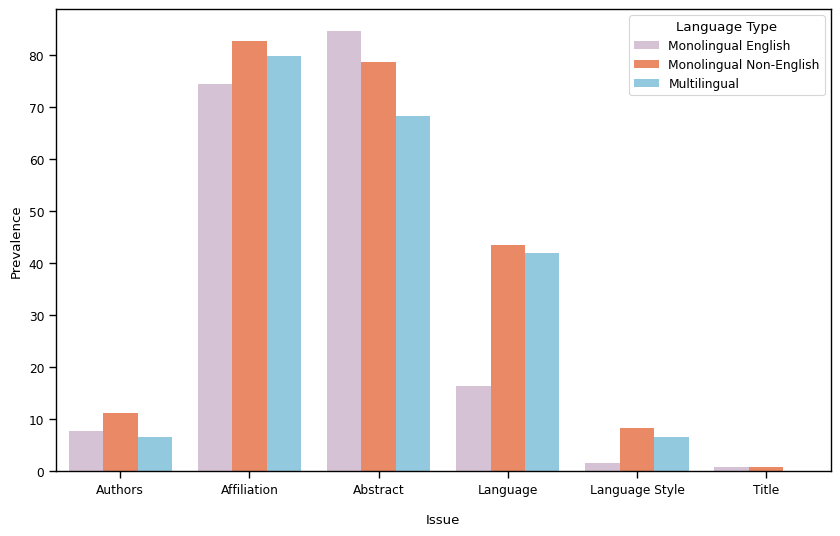

In [5]:
comp_df = df2[['Language Type', 'Authors', 'Affiliation', 'Abstract', 'Language', 'Language Style','Title']]
issue_columns = ['Language Type', 'Authors', 'Affiliation', 'Abstract', 'Language', 'Language Style','Title']
comp_df.Affiliation.fillna(0, inplace=True)
grouped = comp_df.groupby('Language Type', observed=False)[issue_columns].mean(numeric_only=True).reset_index()
melted = grouped.melt(id_vars='Language Type', var_name='issue', value_name='prevalence')
melted['prevalence'] = melted.prevalence.map(lambda x: x*100)

plt.figure(figsize=(10, 6))
sns.barplot(x='issue', y='prevalence', hue='Language Type', data=melted, palette=['thistle','coral', 'skyblue'],
            hue_order=['Monolingual English', 'Monolingual Non-English', 'Multilingual'])
#plt.title('Prevalence of Issues Across Language Types')
plt.xlabel('Issue', labelpad=12.5)
plt.ylabel('Prevalence')
#plt.xticks(rotation=20)
plt.savefig(figure_dir / 'comp_lang_type.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### Quality

A viz similar to above, but pertaining to the quality issues.

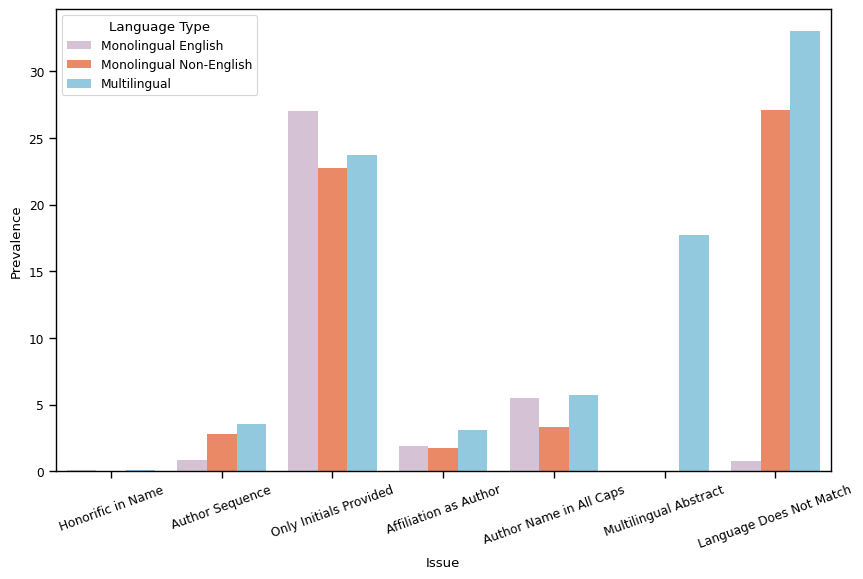

In [6]:
qual_df = df2[['Language Type', 'Author Sequence', 'Only Initials Provided', 'Affiliation as Author',
              'Multilingual Abstract', 'Language Does Not Match',
              'Honorific in Name', 'Author Name in All Caps']]

issue_columns = ['Language Type', 'Honorific in Name', 'Author Sequence', 
                 'Only Initials Provided', 'Affiliation as Author', 'Author Name in All Caps',
                 'Multilingual Abstract', 'Language Does Not Match']
grouped = qual_df.groupby('Language Type', observed=False)[issue_columns].mean(numeric_only=True).reset_index()
melted = grouped.melt(id_vars='Language Type', var_name='issue', value_name='prevalence')
melted['prevalence'] = melted.prevalence.map(lambda x: x*100)

plt.figure(figsize=(10, 6))
sns.barplot(x='issue', y='prevalence', hue='Language Type', data=melted, palette=['thistle','coral', 'skyblue'],
            hue_order=['Monolingual English', 'Monolingual Non-English', 'Multilingual'])
#plt.title('Prevalence of Issues Across Language Types')
plt.xlabel('Issue')
plt.ylabel('Prevalence')
plt.xticks(rotation=20)
plt.savefig(figure_dir / 'quality_lang_type.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### Language Type x Publisher Size

Chart showing the representation of language types across publisher size groups.

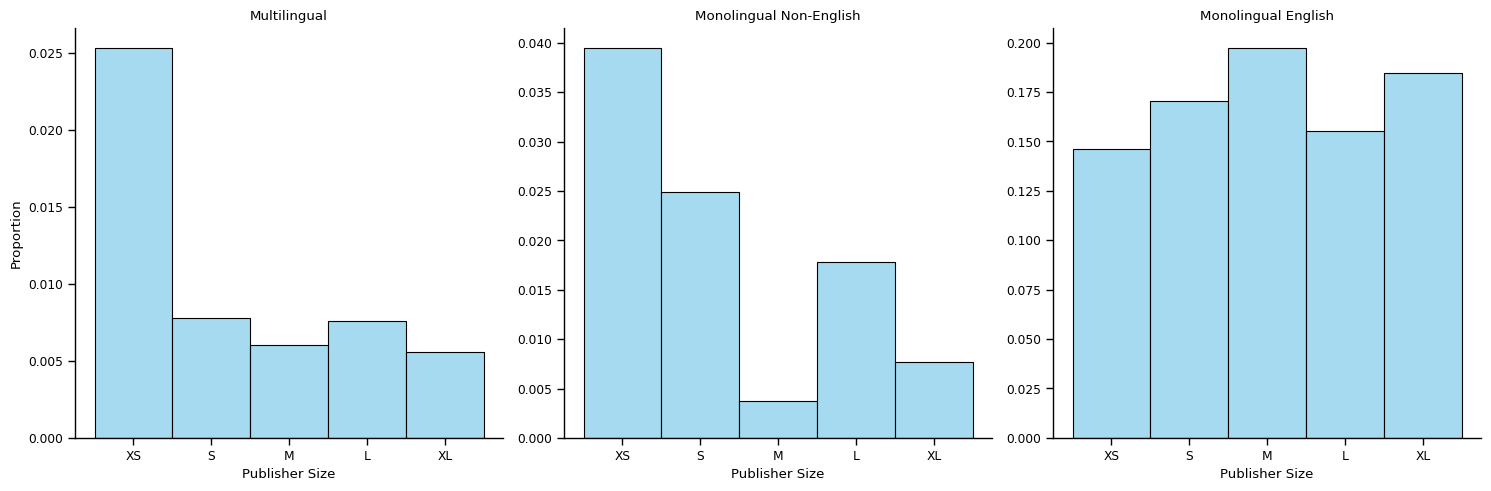

In [7]:
d = sns.displot(df2, x='Publisher Size', stat='proportion', col='Language Type',
                color='skyblue', facet_kws={'sharey':False})
d.set_titles('{col_name}')
plt.savefig(figure_dir / 'pubsize_x_langtype.png', format='png', bbox_inches='tight',
            dpi=600)
plt.show()

### Heatmaps - Issues: Pub Size x Lang Type

First Quality issue, then completeness.

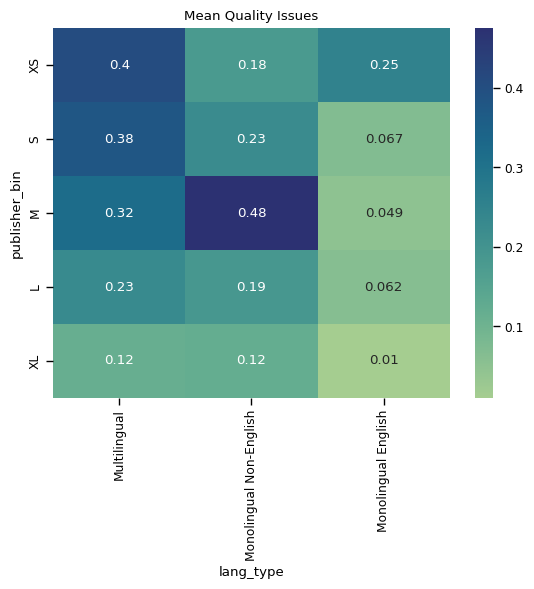

In [8]:
fng = sns.heatmap(pivot, annot=True, cmap ='crest').set(title='Mean Quality Issues')
plt.savefig(figure_dir / 'size_lang_heatmap.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_206361/4073851023.py:1: FutureWarning: The provided callable <function mean at 0x7f29381ab640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(df2, values='completeness_errors', index='Publisher Size',


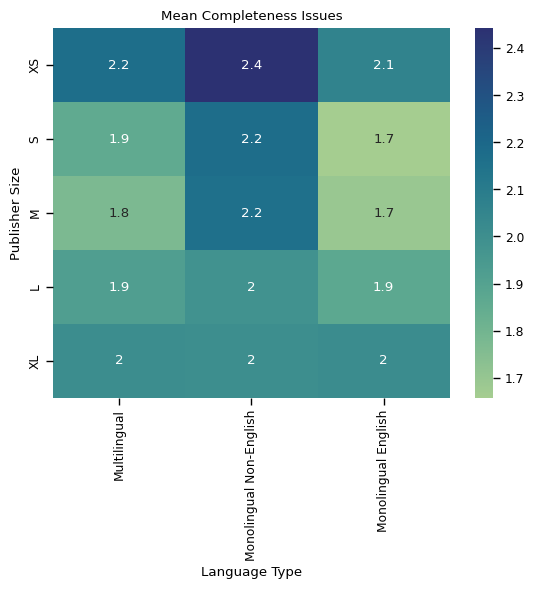

In [9]:
pivot = pd.pivot_table(df2, values='completeness_errors', index='Publisher Size',
                       columns=['Language Type'], aggfunc=np.mean)
fng = sns.heatmap(pivot, annot=True, cmap ='crest').set(title='Mean Completeness Issues')
plt.savefig(figure_dir / 'size_lang_complete_heat.png', format='png', dpi=600)
plt.show()

## Summary statistics

In [10]:
pub_groups = ['XS', 'S', 'M', 'L', 'XL']

for i in pub_groups:
    temp = df.loc[df.publisher_bin == i]
    num_journ = str(temp['container-title'].nunique())
    num_pub = str(temp.publisher.nunique())
    smaller = temp[['publisher', 'DOI']]
    med_rec = smaller.groupby('publisher').count()
    med_rec = str(med_rec.median())
    print(f'{i} -- Journals: {num_journ}, Publishers: {num_pub}, Median Records: {med_rec}\n')


XS -- Journals: 11400, Publishers: 5550, Median Records: DOI    1.0
dtype: float64

S -- Journals: 4596, Publishers: 77, Median Records: DOI    183.0
dtype: float64

M -- Journals: 4745, Publishers: 9, Median Records: DOI    1736.0
dtype: float64

L -- Journals: 4212, Publishers: 2, Median Records: DOI    9184.0
dtype: float64

XL -- Journals: 2562, Publishers: 1, Median Records: DOI    19632.0
dtype: float64



In [12]:
lang_groups = ['Monolingual English', 'Monolingual Non-English', 'Multilingual']

for i in lang_groups:
    temp = df.loc[df.lang_type == i]
    num_rec = str(temp.shape[0])
    num_pub = str(temp.publisher.nunique())
    rec_pub = str(temp.shape[0]/temp.publisher.nunique())
    num_journ = str(temp['container-title'].nunique())
    print(f'{i} -- \n')
    print(f'Records: {num_rec}, Publishers: {num_pub}, Mean: {rec_pub}, Journals: {num_journ}\n')

Monolingual English -- 

Records: 82326, Publishers: 3821, Mean: 21.54566867312222, Journals: 20423

Monolingual Non-English -- 

Records: 9044, Publishers: 1583, Mean: 5.7132027795325335, Journals: 4922

Multilingual -- 

Records: 5053, Publishers: 1310, Mean: 3.8572519083969468, Journals: 2934



In [13]:
temp = df.loc[df.lang_type.isna()]
num_rec = temp.shape[0]
num_pub = temp.publisher.nunique()
rec_pub = temp.shape[0]/temp.publisher.nunique()
num_journ = temp['container-title'].nunique()
print(f'Uncategorized -- \n')
print(f'Records: {num_rec}, Publishers: {num_pub}, Mean: {rec_pub}, Journals: {num_journ}\n')

Uncategorized -- 

Records: 3577, Publishers: 322, Mean: 11.108695652173912, Journals: 1767



### Completeness issues

In [14]:
issues = ['Authors', 'Affiliation', 'Abstract', 'Language', 'Language Style','Title']
comp = df2.loc[(df2['Authors'] == 1) | (df2['Affiliation'] == 1) |
              (df2['Abstract'] == 1) | (df2['Language'] == 1) |
              (df2['Language Style'] == 1) | (df2['Title'] == 1)]
prev_comp = (comp.shape[0]/df2.shape[0]) * 100
print(f'Prevalence of Completeness Issues: {prev_comp}\n')

for i in issues:
    temp = df2.loc[df2[i] == 1]
    prev = (temp.shape[0]/df2.shape[0]) * 100
    print(f'Prevalence of {i} Completeness Issues: {prev}\n')

Prevalence of Completeness Issues: 94.651

Prevalence of Authors Completeness Issues: 9.041

Prevalence of Affiliation Completeness Issues: 74.776

Prevalence of Abstract Completeness Issues: 83.745

Prevalence of Language Completeness Issues: 20.11

Prevalence of Language Style Completeness Issues: 2.024

Prevalence of Title Completeness Issues: 1.036



### Quality Issues

The first set is the prevalence within the entire sample, (# of Records with Issue)/(# of Records in the sample).

The second set looks at each issue as (# of Records with issue)/(# of Records with data within the Field) e.g. (# of Multilingual Abstracts)/(# of Records that have abstracts)

In [15]:
issues = ['Honorific in Name', 'Author Sequence', 
               'Affiliation as Author', 'Author Name in All Caps',
               'Multilingual Abstract', 'Language Does Not Match',
               'Only Initials Provided']

#Status and Language categories. "Value disagrees with parameters of field" Form. Excludes initials in author name
status_lang = df2.loc[(df2['Honorific in Name'] == 1) | (df2['Author Sequence'] == 1) |
               (df2['Affiliation as Author'] == 1) | (df2['Author Name in All Caps'] == 1) |
               (df2['Multilingual Abstract'] == 1) | (df2['Language Does Not Match'] == 1)]
prev_status = (status_lang.shape[0]/df2.shape[0]) * 100
print(f'Prevalence of Status and Language Issues: {prev_status}\n')

for i in issues:
    temp = df2.loc[df2[i] == 1]
    prev = (temp.shape[0]/df2.shape[0]) * 100
    print(f'Prevalence of {i} Quality Issues: {prev}\n')

Prevalence of Status and Language Issues: 9.939

Prevalence of Honorific in Name Quality Issues: 0.08800000000000001

Prevalence of Author Sequence Quality Issues: 1.0710000000000002

Prevalence of Affiliation as Author Quality Issues: 1.764

Prevalence of Author Name in All Caps Quality Issues: 4.7219999999999995

Prevalence of Multilingual Abstract Quality Issues: 0.28300000000000003

Prevalence of Language Does Not Match Quality Issues: 2.4899999999999998

Prevalence of Only Initials Provided Quality Issues: 24.111



In [16]:
issue_dict = {'Multilingual Abstract': 'abstract',
              'Honorific in Name': 'author',
              'Author Sequence': 'author',
              'Affiliation as Author' : 'author',
              'Author Name in All Caps': 'author',
              'Language Does Not Match': 'language',
              'Only Initials Provided' : 'author'}

for k,v in issue_dict.items():
    temp = df2.loc[df2[k] == 1]
    other = df.loc[df[v].notnull()]
    prev = (temp.shape[0]/other.shape[0]) * 100
    print(f'Prevalence of {k} Quality Issues: {prev}\n')


Prevalence of Multilingual Abstract Quality Issues: 1.7410027683789604

Prevalence of Honorific in Name Quality Issues: 0.09674688595960818

Prevalence of Author Sequence Quality Issues: 1.1774535779856858

Prevalence of Affiliation as Author Quality Issues: 1.9393353049176003

Prevalence of Author Name in All Caps Quality Issues: 5.191349948878066

Prevalence of Language Does Not Match Quality Issues: 3.1167855801727375

Prevalence of Only Initials Provided Quality Issues: 26.50754735650128



### Author Sequence Seperation

To get numbers about which specific Author sequence issue is occuring, All first Authors or No First authors, we'll run the function again, but we'll return specific information: `All First` or `No First`

In [17]:
import ast
def reformat_col(record):
    try:
        formed = ast.literal_eval(record)
        return formed
    except:
        return None

cols_to_reformat = ['author']
for col in cols_to_reformat:
    df[col] = df[col].apply(lambda x: reformat_col(x))

In [18]:
def sequence_checker(authorList):
    counter = 0 
    try: 
        for author in authorList:
                if 'name' in author.keys():
                    if len(authorList) == 1:
                        counter +=1
                    else:
                        continue
                else:
                    if author['sequence'] == 'first':
                        counter +=1
                    else:
                        continue
        if counter == 0:
            return 'No First' #no first author
        elif len(authorList) > 1:
            if counter > 1:
                return 'All First' #multiple first authors
            else:
                return 0
        else:
            return 0 #no issue
    except:
        return None

    

In [19]:
df['author_sequence'] = df.author.map(lambda x: sequence_checker(x))
df.author_sequence.value_counts()

author_sequence
0            89888
All First      799
No First       272
Name: count, dtype: int64

In [20]:
options = ['All First', 'No First']

for o in options:
    temp = df.loc[df.author_sequence == o]
    prev_all = (temp.shape[0]/df.shape[0]) * 100
    author_excl = df.loc[df.author.notnull()]
    prev_excl = (temp.shape[0]/author_excl.shape[0]) * 100
    print(f'Prevalence (pop=entire sample) of {o} Sequence issue: {prev_all}\n')
    print(f'Prevalence (records with authors) of {o} Sequence issue: {prev_excl}\n')

Prevalence (pop=entire sample) of All First Sequence issue: 0.799

Prevalence (records with authors) of All First Sequence issue: 0.8784177486559878

Prevalence (pop=entire sample) of No First Sequence issue: 0.272

Prevalence (records with authors) of No First Sequence issue: 0.29903582932969797



### Category Prevalence

Status, Language categories

Table 4

In [21]:
status = ['Affiliation', 'Affiliation as Author', 'Honorific in Name',
          'Author Name in All Caps', 'Author Sequence']

status_df = df2.loc[(df2[status[0]] == 1) | (df2[status[1]] == 1) |
                     (df2[status[2]] == 1) | (df2[status[3]] == 1) |
                     (df2[status[4]] == 1)]
prev_status = (status_df.shape[0]/df2.shape[0]) * 100
print(f'Prevalence of Status Issues: {prev_status}\n')

Prevalence of Status Issues: 75.908



In [22]:
lang = ['Multilingual Abstract', 'Language Does Not Match',
        'Language', 'Language Style']

lang_df = df2.loc[(df2[lang[0]] == 1) | (df2[lang[1]] == 1) |
                     (df2[lang[2]] == 1) | (df2[lang[3]] == 1)]
prev_lang = (lang_df.shape[0]/df2.shape[0]) * 100
print(f'Prevalence of Language Issues: {prev_lang}\n')

Prevalence of Language Issues: 23.754

